In [2]:
import numpy as np
import os
import glob
import random
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K

from sklearn.model_selection import train_test_split
from patchify import patchify, unpatchify
from skimage import morphology, img_as_bool, img_as_ubyte, color, io
from skimage.morphology import skeletonize
from skan import Skeleton, summarize, draw
from skan.csr import skeleton_to_csgraph
import networkx as nx

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda


In [17]:
def crop_petri_dish(image):

    if len(image.shape) > 2:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image
    # apply Gaussian Blur to smooth the image
    blurred = cv2.GaussianBlur(gray_image, (9, 9), 0)
    # apply binary threshold
    _, thresh = cv2.threshold(blurred, 10, 255, cv2.THRESH_BINARY) 
    
    # finding contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # filtering out very large contours which might be the image borders
    contours = [cnt for cnt in contours if cv2.contourArea(cnt) < image.shape[0] * image.shape[1] * 0.95]

    # findng the largest contour which will be the petri dish
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # modify the bounding rectangle to crop more tightly, the margin can be changed
    margin = 90
    x += margin
    y += margin
    w -= 2 * margin
    h -= 2 * margin
    
    # ensuring the modified coordinates are within image bounds
    x = max(x, 0)
    y = max(y, 0)
    w = min(w, image.shape[1] - x)
    h = min(h, image.shape[0] - y)

    # cropping the image based on calculated coordinates
    cropped_image = image[y:y+h, x:x+w]

    return cropped_image, (x, y, w, h)

In [18]:
def apply_crop(image, bbox):
    x, y, w, h = bbox
    return image[y:y+h, x:x+w]

In [10]:
def padder(image, patch_size):
    """
    Adds padding to an image to make its dimensions divisible by a specified patch size.

    This function calculates the amount of padding needed for both the height and width of an image so that its dimensions become divisible by the given patch size. The padding is applied evenly to both sides of each dimension (top and bottom for height, left and right for width). If the padding amount is odd, one extra pixel is added to the bottom or right side. The padding color is set to black (0, 0, 0).

    Parameters:
    - image (numpy.ndarray): The input image as a NumPy array. Expected shape is (height, width, channels).
    - patch_size (int): The patch size to which the image dimensions should be divisible. It's applied to both height and width.

    Returns:
    - numpy.ndarray: The padded image as a NumPy array with the same number of channels as the input. Its dimensions are adjusted to be divisible by the specified patch size.

    Example:
    - padded_image = padder(cv2.imread('example.jpg'), 128)

    """
    h = image.shape[0]
    w = image.shape[1]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w

    top_padding = int(height_padding/2)
    bottom_padding = height_padding - top_padding

    left_padding = int(width_padding/2)
    right_padding = width_padding - left_padding

    image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return image

In [11]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### The first part of the code is to create the mask predictions. It takes the input, which are the raw images, then resizes them, crops them, pads them, loads the model and predicts the mask, unpatchifies and saves all of the predictions.

In [ ]:
image_dir = ""
output_dir = ""

scaling_factor = 1.0
patch_size = 128

image_paths = sorted(glob.glob(os.path.join(image_dir, "*.png")))

for idx, img_path in enumerate(image_paths):
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (0, 0), fx=scaling_factor, fy=scaling_factor)
    image, bbox = crop_petri_dish(image)
    image_padded = padder(image, patch_size)
    image_patches = patchify(image_padded, (patch_size, patch_size, 3), step=patch_size)
    #image_patches = patchify(image_padded, (patch_size, patch_size, 3), step=patch_size).reshape(-1, patch_size, patch_size)
    image_patches = np.squeeze(image_patches)
    i = image_patches.shape[0]
    j = image_patches.shape[1] 
    image_patches_reshaped = image_patches.reshape(-1, patch_size, patch_size, 3)
    predicted_mask = model.predict(image_patches_reshaped/255)
    predicted_mask = predicted_mask.reshape(i, j, 128, 128) 
    num_patches = predicted_mask.shape[0]
    target_shape = (num_patches * patch_size, num_patches * patch_size)
    predicted_mask = unpatchify(predicted_mask, target_shape)

    output_path = os.path.join(output_dir, f"predicted_mask_{idx}.png")
    cv2.imwrite(output_path, predicted_mask * 255)

### The second one does the same things as the first but the functions are modified to better suit a model that is 256 patch size. 

In [16]:
def extract_number(filename):
    parts = re.findall(r'\d+', filename)
    return int(parts[-1]) if parts else 0

def crop_petri_dish(image):
    
    return image, (0, 0, image.shape[1], image.shape[0])

def padder(image, target_size):
    
    height, width, channels = image.shape
    pad_height = (target_size - height % target_size) % target_size
    pad_width = (target_size - width % target_size) % target_size
    padded_image = cv2.copyMakeBorder(image, 0, pad_height, 0, pad_width, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return padded_image

def patchify(img, patch_shape, step):
    
    img_height, img_width, channels = img.shape
    patches = []
    for i in range(0, img_height, step):
        for j in range(0, img_width, step):
            patch = img[i:i + patch_shape[0], j:j + patch_shape[1]]
            if patch.shape[0] == patch_shape[0] and patch.shape[1] == patch_shape[1]:
                patches.append(patch)
    return np.array(patches)

def unpatchify(patches, target_shape):
    
    patch_height, patch_width = patches.shape[1], patches.shape[2]
    num_patches = patches.shape[0]
    img_height, img_width = target_shape[0], target_shape[1]
    
    
    num_patches_height = img_height // patch_height
    num_patches_width = img_width // patch_width
    
    image = np.zeros(target_shape, dtype=patches.dtype)
    
    patch_idx = 0
    for i in range(num_patches_height):
        for j in range(num_patches_width):
            if patch_idx < num_patches:
                image[i * patch_height:(i + 1) * patch_height,
                      j * patch_width:(j + 1) * patch_width] = patches[patch_idx]
                patch_idx += 1
    
    return image

# Load the trained model
model_path = 'emil_23100111_unet_model_256px.h5'
model = load_model(model_path, custom_objects={"f1": f1})

image_dir = r"C:\Users\emilp\Documents\GitHub\Y2B-2023-OT2_Twin\textures\_plates"
output_dir = r"C:\Users\emilp\Documents\GitHub\Y2B-2023-OT2_Twin\textures\plates_preds"
os.makedirs(output_dir, exist_ok=True)

image_paths = sorted(glob.glob(os.path.join(image_dir, "*.png")), key=extract_number)

for idx, img_path in enumerate(image_paths):
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    
    cropped_image, bbox = crop_petri_dish(image)
    padded_image = padder(cropped_image, 256)
    original_size = padded_image.shape[:2]
    image_patches = patchify(padded_image, (256, 256, 3), 256)
    image_patches_reshaped = image_patches.reshape(-1, 256, 256, 3)
    
    predicted_masks = model.predict(image_patches_reshaped / 255.0)
    predicted_mask = predicted_masks.reshape(-1, 256, 256)
    combined_mask = unpatchify(predicted_mask, padded_image.shape[:2])
    
    final_mask = combined_mask[:original_size[0], :original_size[1]]
    output_path = os.path.join(output_dir, f"predicted_mask_{idx}.png")
    cv2.imwrite(output_path, final_mask * 255)


7/7 [==============================] - 1s 103ms/step


### This code takes the predicted masks as input, skeletonizes them, then it labels the connected components it finds the largest component and contructs a graph where the nodes represent the pixels. It uses Dijktras algorithm to find hte longest path. Then it draws the found path on the mask. To properly find each plant and analize them individually, the mask is divided in 5 parts and then the biggest areas for each section is analyzed.

Longest path length for segment 1: 384 pixels
Longest path length for segment 2: 361 pixels
Longest path length for segment 3: 10 pixels
Longest path length for segment 4: 382 pixels
Longest path length for segment 5: 370 pixels


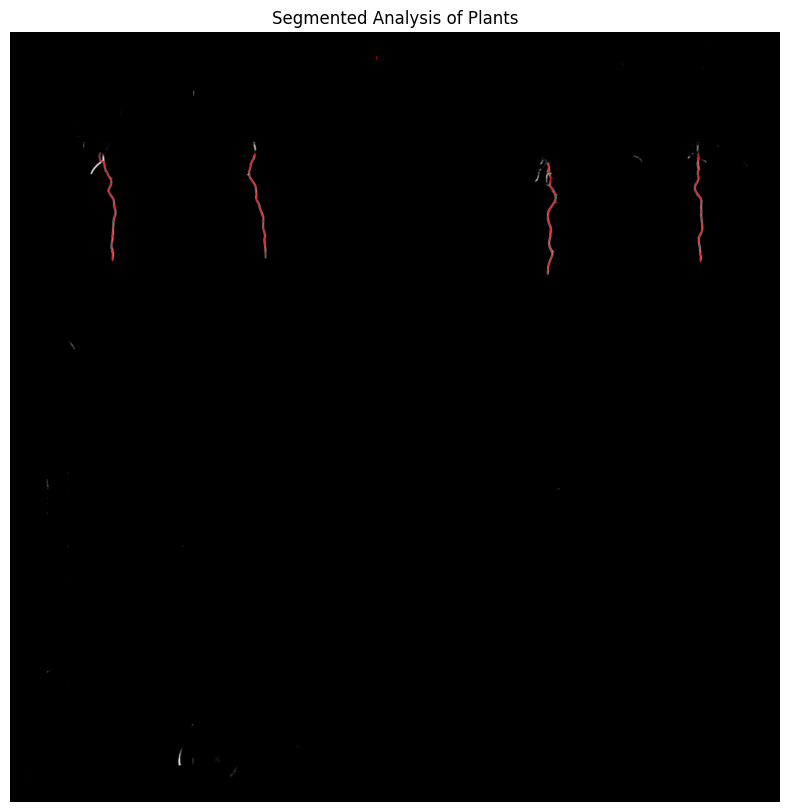

In [200]:
def display_image(img, title="Image", cmap='gray'):
    """Display an image with matplotlib."""
    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

def skeletonize_image(image):
    """Convert image to binary and apply skeletonization."""
    _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    skeleton = morphology.skeletonize(binary_image > 0)
    return skeleton

def analyze_skeleton(skeleton):
    """Analyze skeleton to find the longest path using Dijkstra's algorithm."""
    labeled_skeleton, _ = measure.label(skeleton, connectivity=2, return_num=True)
    properties = measure.regionprops(labeled_skeleton)
    
    if properties:
        largest_component = max(properties, key=lambda x: x.area).label
        main_skeleton = labeled_skeleton == largest_component
        graph = nx.Graph()
        for r, c in np.argwhere(main_skeleton):
            for offsets in [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]:
                rr, cc = r + offsets[0], c + offsets[1]
                if 0 <= rr < skeleton.shape[0] and 0 <= cc < skeleton.shape[1] and main_skeleton[rr, cc]:
                    graph.add_edge((r, c), (rr, cc))
        
        if nx.is_empty(graph):
            return [], 0
        
        path = nx.dijkstra_path(graph, source=list(graph.nodes())[0], target=list(graph.nodes())[-1])
        length = nx.dijkstra_path_length(graph, source=list(graph.nodes())[0], target=list(graph.nodes())[-1])
        return path, length
    return [], 0

def draw_path_on_image(image, path, color=(255, 0, 0)):
    """Draw the path on the image."""
    for i in range(len(path)-1):
        cv2.line(image, (path[i][1], path[i][0]), (path[i+1][1], path[i+1][0]), color, 2)

# Load the image in color
image_path = r"C:\Users\emilp\Documents\Buas_Y2\Block_B\data_sets\Kaggle\predicted masks\final2\predicted_mask_15.png"
original_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
segment_width = gray_image.shape[1] // 5

overlay_image = original_image.copy()  # Copy of the original image for drawing paths

for i in range(5):
    x_start = i * segment_width
    x_end = (i + 1) * segment_width if i < 4 else gray_image.shape[1]
    cropped_image = gray_image[:, x_start:x_end]
    skeletonized_image = skeletonize_image(cropped_image)
    path, length = analyze_skeleton(skeletonized_image)
    
    if path:
        print(f"Longest path length for segment {i+1}: {length} pixels")
        adjusted_path = [(r, c + x_start) for r, c in path]  # Adjust path coordinates for the segment
        draw_path_on_image(overlay_image, adjusted_path)
    else:
        print(f"No valid path found for segment {i+1}")

display_image(overlay_image, "Segmented Analysis of Plants")


### This is the same but its saved in a csv file.

In [109]:
import cv2
import os
import numpy as np
import pandas as pd
from skimage import morphology, measure
import networkx as nx
import re

def sort_numerically(file_list):
    """Sort file list numerically based on numbers in filenames."""
    return sorted(file_list, key=lambda x: int(re.search(r'\d+', x).group()))

def skeletonize_image(image):
    """Convert image to binary and apply skeletonization."""
    _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    skeleton = morphology.skeletonize(binary_image > 0)
    return skeleton

def analyze_skeleton(skeleton):
    """Analyze skeleton to find the longest path using Dijkstra's algorithm."""
    labeled_skeleton, _ = measure.label(skeleton, connectivity=2, return_num=True)
    properties = measure.regionprops(labeled_skeleton)

    if properties:
        largest_component = max(properties, key=lambda x: x.area).label
        main_skeleton = labeled_skeleton == largest_component
        graph = nx.Graph()
        for r, c in np.argwhere(main_skeleton):
            for offsets in [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]:
                rr, cc = r + offsets[0], c + offsets[1]
                if 0 <= rr < skeleton.shape[0] and 0 <= cc < skeleton.shape[1] and main_skeleton[rr, cc]:
                    graph.add_edge((r, c), (rr, cc))

        if len(graph.nodes) > 1:  # Ensure there are enough nodes for a path
            path = nx.dijkstra_path(graph, source=list(graph.nodes())[0], target=list(graph.nodes())[-1])
            length = nx.dijkstra_path_length(graph, source=list(graph.nodes())[0], target=list(graph.nodes())[-1])

            # Ignore paths shorter than 30 pixels
            if length < 30:
                return [], 0

            return path, length
    return [], 0

def process_folder_to_csv_numerical(image_folder, output_csv):
    """Process a folder of images and save the pixel lengths into a CSV file in strict numerical order."""
    results = []
    # Ensure images are sorted numerically based on numbers in their filenames
    image_files = sort_numerically([f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))])

    for image_idx, image_file in enumerate(image_files, start=1):
        image_path = os.path.join(image_folder, image_file)
        original_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
        segment_width = gray_image.shape[1] // 5

        for segment_idx in range(5):
            x_start = segment_idx * segment_width
            x_end = (segment_idx + 1) * segment_width if segment_idx < 4 else gray_image.shape[1]
            cropped_image = gray_image[:, x_start:x_end]
            skeletonized_image = skeletonize_image(cropped_image)
            path, length = analyze_skeleton(skeletonized_image)

            # Generate Plant ID in the correct order
            plant_id = f"test_image_{image_idx}_plant_{segment_idx + 1}"
            if not path or length < 30:
                length = 0  # Assign 0 if the path is below the threshold

            # Append to results in strict numerical order
            results.append({"Plant ID": plant_id, "Length (px)": length})

    # Save the results to a CSV file
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_csv, index=False)
    print(f"Results saved to {output_csv}")

# Parameters
image_folder = r"C:\Users\emilp\Documents\Buas_Y2\Block_B\data_sets\Kaggle\predicted masks\112"
output_csv = r"C:\Users\emilp\Documents\Buas_Y2\Block_B\data_sets\results_correct_orderr.csv"

# Process the folder and save to CSV in numerical order
process_folder_to_csv_numerical(image_folder, output_csv)


Results saved to C:\Users\emilp\Documents\Buas_Y2\Block_B\data_sets\results_correct_orderr.csv


### This one is the same but instead highlights the root tips.


Processing predicted_mask_0_cropped.png...

📏 test_image_1_plant_1: Length = 145 pixels, Root Tip = (497, 270)
📏 test_image_1_plant_2: Length = 270 pixels, Root Tip = (578, 807)
📏 test_image_1_plant_3: Length = 237 pixels, Root Tip = (553, 1303)
📏 test_image_1_plant_4: Length = 255 pixels, Root Tip = (544, 1832)
📏 test_image_1_plant_5: Length = 243 pixels, Root Tip = (545, 2337)


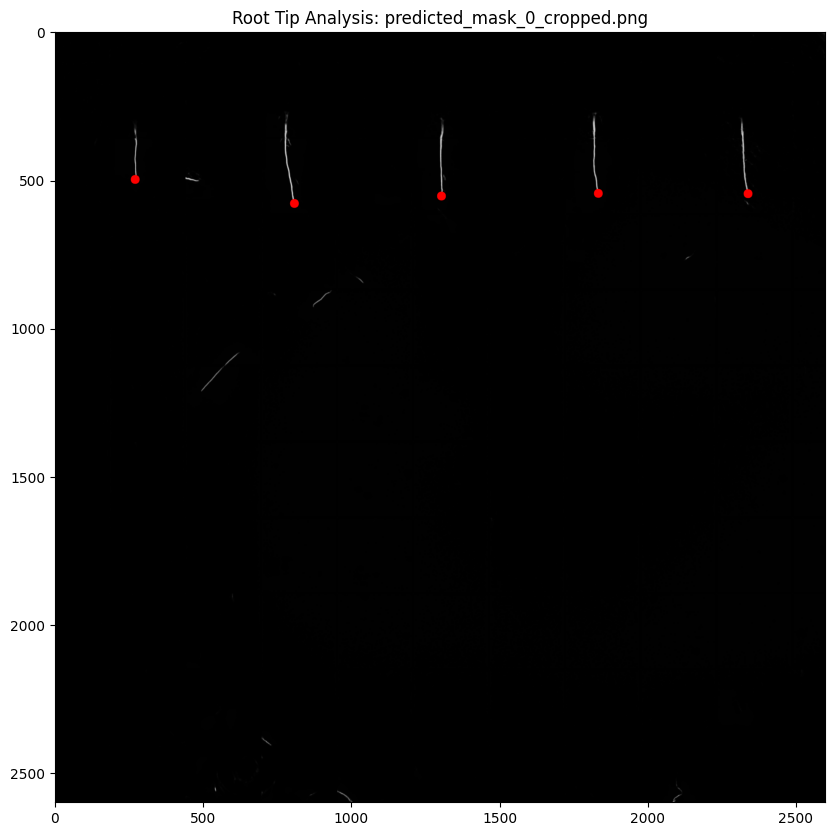


Processing predicted_mask_1_cropped.png...

📏 test_image_2_plant_1: Length = 411 pixels, Root Tip = (833, 261)
📏 test_image_2_plant_2: Length = 291 pixels, Root Tip = (669, 740)
📏 test_image_2_plant_3: Length = 396 pixels, Root Tip = (831, 1348)
📏 test_image_2_plant_4: Length = 190 pixels, Root Tip = (646, 1860)
📏 test_image_2_plant_5: Length = 325 pixels, Root Tip = (784, 2380)


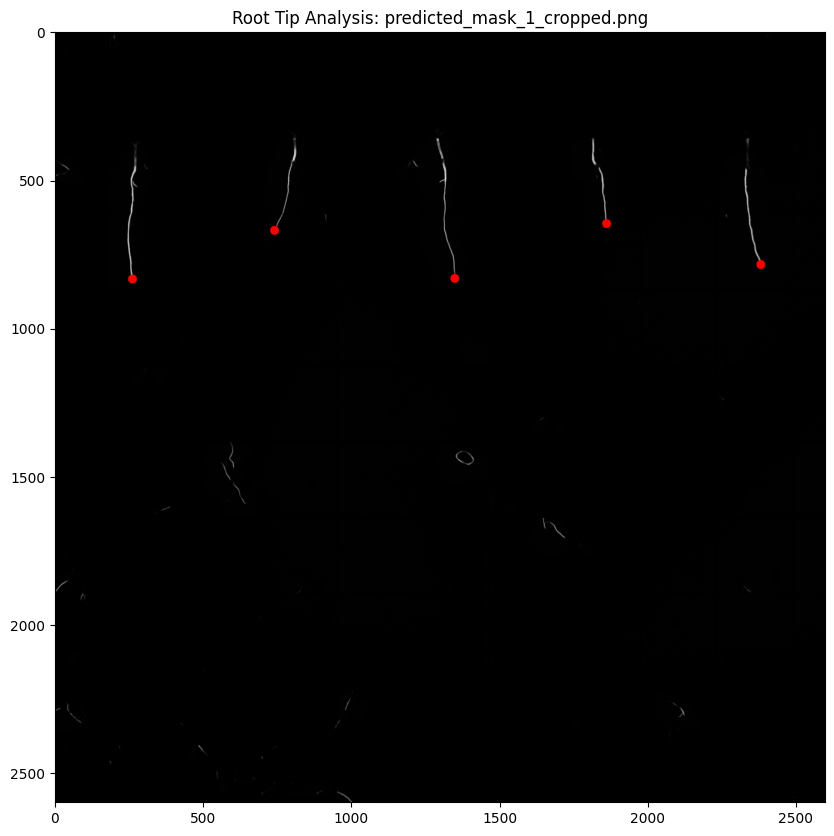


Processing predicted_mask_2_cropped.png...

📏 test_image_3_plant_1: Length = 725 pixels, Root Tip = (1125, 292)
📏 test_image_3_plant_2: Length = 589 pixels, Root Tip = (997, 928)
📏 test_image_3_plant_3: Length = 820 pixels, Root Tip = (1076, 1356)
📏 test_image_3_plant_4: Length = 475 pixels, Root Tip = (870, 1842)
📏 test_image_3_plant_5: Length = 519 pixels, Root Tip = (921, 2392)


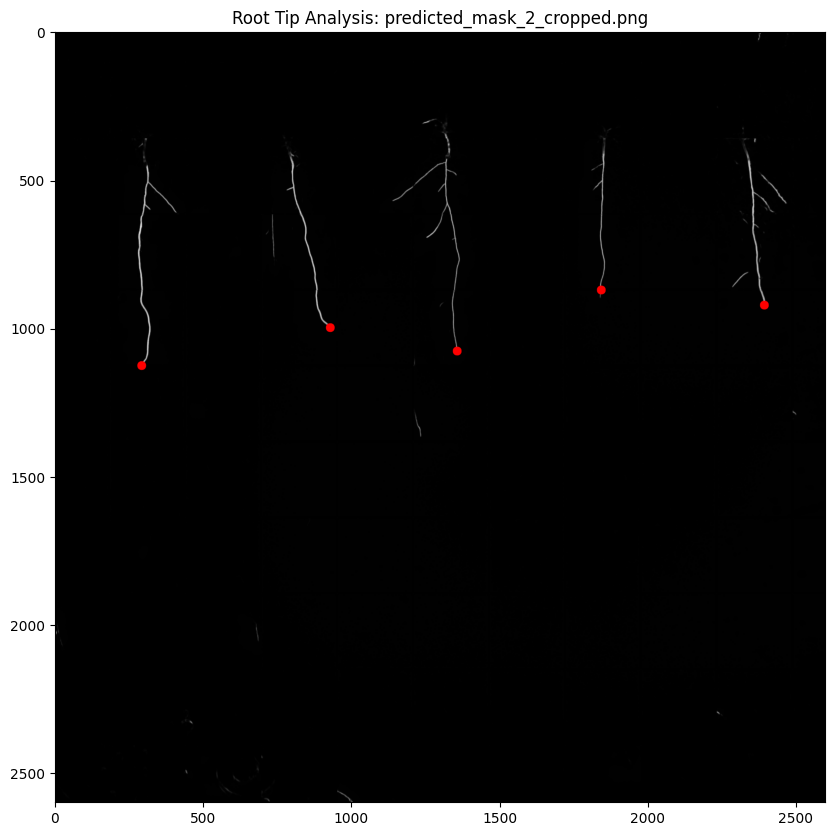


Processing predicted_mask_3_cropped.png...

📏 test_image_4_plant_1: Length = 938 pixels, Root Tip = (1318, 372)
📏 test_image_4_plant_2: Length = 750 pixels, Root Tip = (1072, 818)
📏 test_image_4_plant_3: Length = 691 pixels, Root Tip = (1064, 1322)
📏 test_image_4_plant_4: Length = 670 pixels, Root Tip = (1039, 1799)
📏 test_image_4_plant_5: Length = 667 pixels, Root Tip = (1090, 2360)


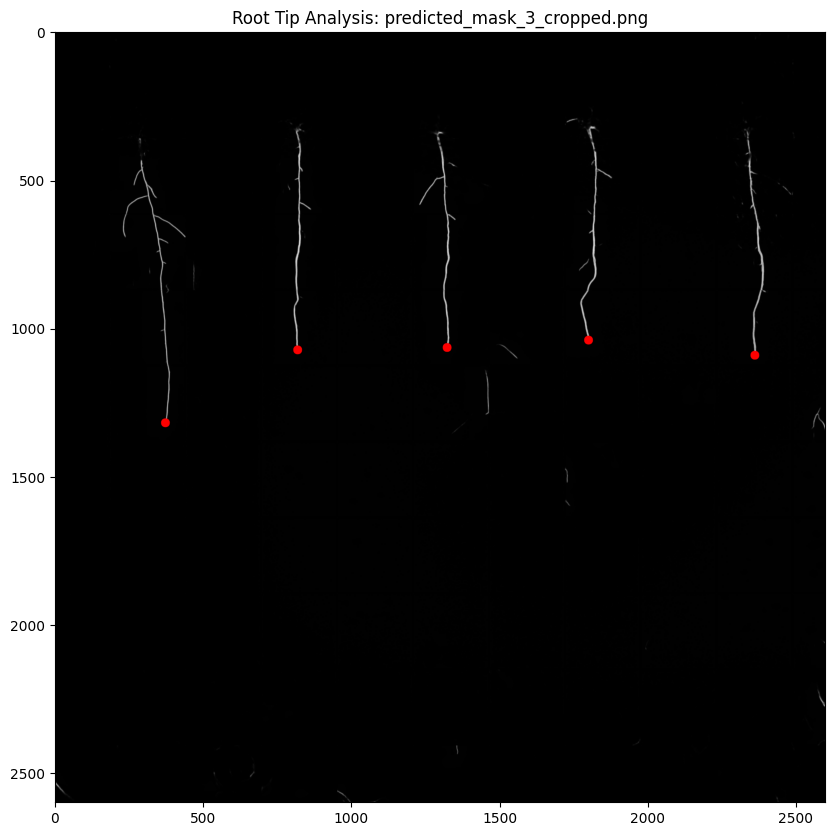


Processing predicted_mask_4_cropped.png...

📏 test_image_5_plant_1: Length = 1082 pixels, Root Tip = (1334, 223)
📏 test_image_5_plant_2: Length = 799 pixels, Root Tip = (1111, 874)
📏 test_image_5_plant_3: Length = 985 pixels, Root Tip = (1327, 1348)
📏 test_image_5_plant_4: Length = 911 pixels, Root Tip = (1277, 1896)
📏 test_image_5_plant_5: Length = 796 pixels, Root Tip = (1229, 2444)


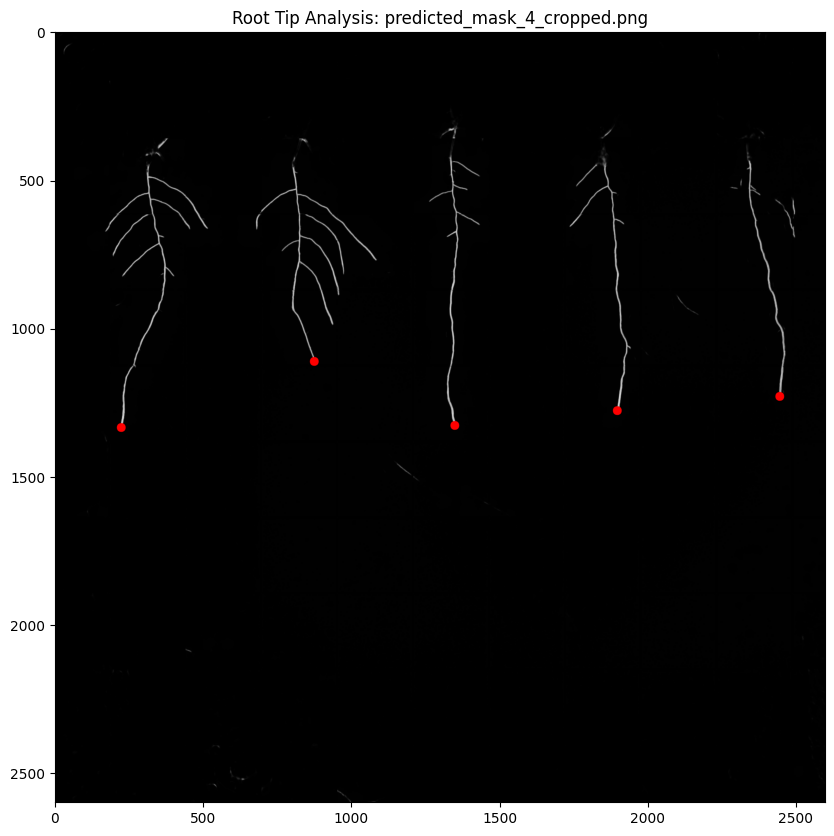


Processing predicted_mask_5_cropped.png...

📏 test_image_6_plant_1: Length = 1136 pixels, Root Tip = (1379, 216)
📏 test_image_6_plant_2: Length = 783 pixels, Root Tip = (1095, 847)
📏 test_image_6_plant_3: Length = 1057 pixels, Root Tip = (1381, 1359)
📏 test_image_6_plant_4: Length = 972 pixels, Root Tip = (1319, 1886)
📏 test_image_6_plant_5: Length = 852 pixels, Root Tip = (1286, 2448)


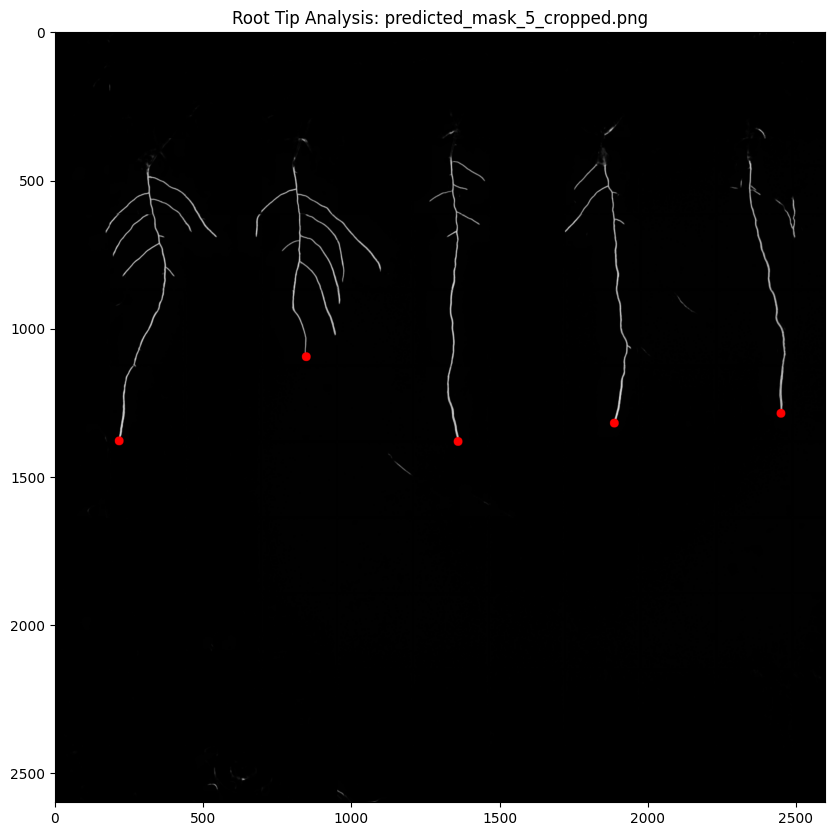


Processing predicted_mask_6_cropped.png...

📏 test_image_7_plant_1: Length = 527 pixels, Root Tip = (880, 259)
📏 test_image_7_plant_2: Length = 548 pixels, Root Tip = (942, 792)
📏 test_image_7_plant_3: Length = 536 pixels, Root Tip = (878, 1300)
📏 test_image_7_plant_4: Length = 644 pixels, Root Tip = (977, 1919)
📏 test_image_7_plant_5: Length = 621 pixels, Root Tip = (1015, 2324)


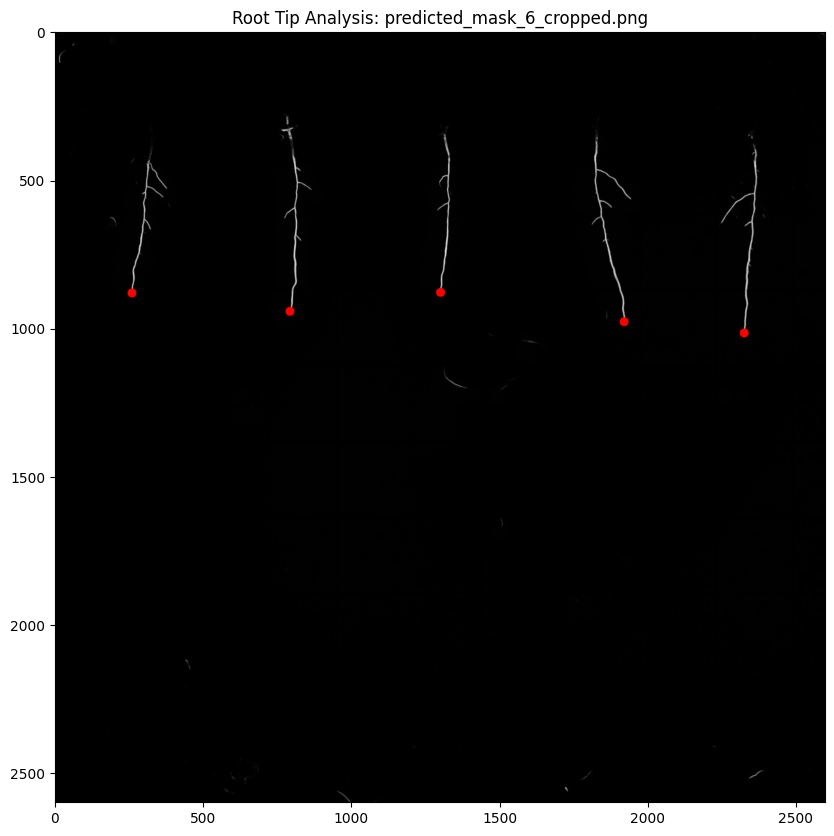


Processing predicted_mask_7_cropped.png...

📏 test_image_8_plant_1: Length = 1422 pixels, Root Tip = (1693, 513)
📏 test_image_8_plant_2: Length = 1574 pixels, Root Tip = (1766, 746)
📏 test_image_8_plant_3: Length = 762 pixels, Root Tip = (866, 1351)
📏 test_image_8_plant_4: Length = 1236 pixels, Root Tip = (1470, 1794)
📏 test_image_8_plant_5: Length = 1093 pixels, Root Tip = (1538, 2583)


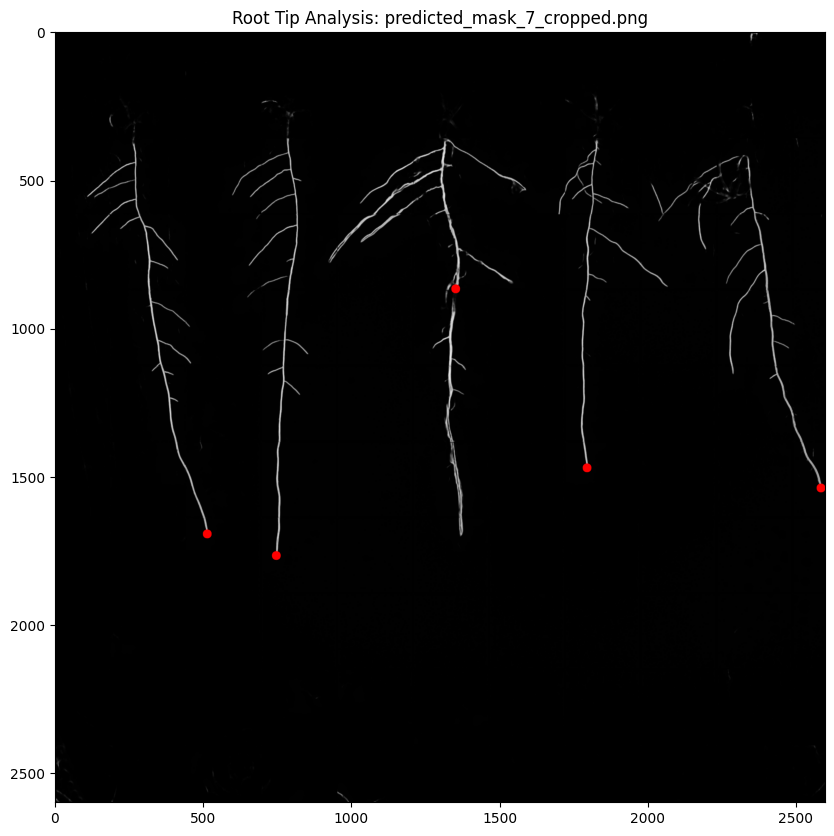


Processing predicted_mask_8_cropped.png...



KeyboardInterrupt: 

In [3]:
import cv2
import os
import numpy as np
import pandas as pd
from skimage import morphology, measure
import networkx as nx
import re
import matplotlib.pyplot as plt

def sort_numerically(file_list):
    return sorted(file_list, key=lambda x: int(re.search(r'\d+', x).group()))

def preprocess_image(image):
    _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((5, 5), np.uint8)
    closed_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)
    dilated_image = cv2.dilate(closed_image, kernel, iterations=1)
    return dilated_image

def skeletonize_image(image):
    processed_image = preprocess_image(image)
    skeleton = morphology.skeletonize(processed_image > 0)
    return skeleton

def analyze_skeleton(skeleton):
    labeled_skeleton, _ = measure.label(skeleton, connectivity=2, return_num=True)
    properties = measure.regionprops(labeled_skeleton)

    if properties:
        largest_component = max(properties, key=lambda x: x.area).label
        main_skeleton = labeled_skeleton == largest_component
        graph = nx.Graph()
        for r, c in np.argwhere(main_skeleton):
            for offsets in [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]:
                rr, cc = r + offsets[0], c + offsets[1]
                if 0 <= rr < skeleton.shape[0] and 0 <= cc < skeleton.shape[1] and main_skeleton[rr, cc]:
                    graph.add_edge((r, c), (rr, cc))

        if len(graph.nodes) > 1:
            endpoints = [node for node, degree in graph.degree() if degree == 1]
            if len(endpoints) < 2:
                return [], 0, None

            max_length = 0
            longest_path = []
            for i in range(len(endpoints)):
                for j in range(i + 1, len(endpoints)):
                    try:
                        path = nx.shortest_path(graph, source=endpoints[i], target=endpoints[j])
                        length = len(path)
                        if length > max_length:
                            max_length = length
                            longest_path = path
                    except nx.NetworkXNoPath:
                        continue

            if max_length < 30:
                return [], 0, None

            root_tip = longest_path[-1]
            return longest_path, max_length, root_tip
    return [], 0, None

def draw_root_tip_on_image(image, root_tip, color=(0, 0, 255)):
    if root_tip and None not in root_tip:
        cv2.circle(image, (root_tip[1], root_tip[0]), radius=15, color=color, thickness=-1)

def process_folder_to_csv_numerical(image_folder, output_csv):
    results = []
    image_files = sort_numerically([f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))])

    for image_idx, image_file in enumerate(image_files, start=1):
        image_path = os.path.join(image_folder, image_file)
        original_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
        ignore_top = int(gray_image.shape[0] * 0.10)
        filtered_gray_image = gray_image[ignore_top:, :]
        segment_width = filtered_gray_image.shape[1] // 5
        overlay_image = original_image.copy()

        print(f"\nProcessing {image_file}...\n")
        for segment_idx in range(5):
            x_start = segment_idx * segment_width
            x_end = (segment_idx + 1) * segment_width if segment_idx < 4 else filtered_gray_image.shape[1]
            cropped_segment = filtered_gray_image[:, x_start:x_end]
            skeletonized_segment = skeletonize_image(cropped_segment)
            path, length, root_tip = analyze_skeleton(skeletonized_segment)
            plant_id = f"test_image_{image_idx}_plant_{segment_idx + 1}"

            if not path or length < 30:
                length = 0
                root_tip = None
            root_tip_adjusted = (root_tip[0] + ignore_top, root_tip[1] + x_start) if root_tip else (None, None)
            if root_tip_adjusted and None not in root_tip_adjusted:
                draw_root_tip_on_image(overlay_image, root_tip_adjusted)

            results.append({
                "Plant ID": plant_id,
                "Length (px)": length,
                "Root Tip (x, y)": root_tip_adjusted
            })

            print(f"📏 {plant_id}: Length = {length} pixels, Root Tip = {root_tip_adjusted}")

        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))
        plt.title(f"Root Tip Analysis: {image_file}")
        plt.show()

    results_df = pd.DataFrame(results)
    results_df.to_csv(output_csv, index=False)
    print(f"\n📂 Results saved to {output_csv}")

image_folder = r"C:\Users\emilp\Documents\GitHub\Y2B-2023-OT2_Twin\textures\plates_preds"
output_csv = r"C:\Users\emilp\Documents\Buas_Y2\Block_B\data_sets\results_root_tips_only.csv"

process_folder_to_csv_numerical(image_folder, output_csv)